In [1]:
import sys

sys.path.append("../")

import torch

from torchemlp.groups import Group, S, rel_err
from torchemlp.ops import LinearOperator, MatrixLinearOperator
from torchemlp.reps import V, T
from torchemlp.utils import vis, vis_basis, DEFAULT_DEVICE  # , rel_err

In [2]:
class Alt(Group):
    """The alternating group in n dimensions"""

    def __init__(self, n):
        assert n > 2

        h_dense = torch.zeros((n - 2, n, n), device=DEFAULT_DEVICE) + torch.eye(
            n, device=DEFAULT_DEVICE
        )
        for i in range(n - 2):
            ids = torch.tensor([0, 1, i + 2], device=DEFAULT_DEVICE)
            permed_ids = torch.roll(ids, 1)  # cyclic permutation (0,1,i+2)->(i+2,0,1)
            h_dense[i, ids] = h_dense[i, permed_ids]

        self.discrete_generators = [MatrixLinearOperator(h) for h in h_dense]

        super().__init__(n)

In [3]:
print("T5 basis for Alt(5) of shape ", T(5)(Alt(5)).equivariant_basis().shape)
print("T5 basis for S(5) of shape ", T(5)(S(5)).equivariant_basis().shape)

T5 basis for Alt(5) of shape  torch.Size([3125, 63])


Krylov Solving for Equivariant Subspace r<=10: 100%|█| 100/100 [00:01<00:00, 97.
Krylov Solving for Equivariant Subspace r<=20: 100%|█| 100/100 [00:00<00:00, 100
Krylov Solving for Equivariant Subspace r<=40: 100%|█| 100/100 [00:01<00:00, 97.
Krylov Solving for Equivariant Subspace r<=80: 100%|█| 100/100 [00:01<00:00, 93.

T5 basis for S(5) of shape  torch.Size([3125, 52])


In [4]:
G = Alt(5)
rep = T(5)(G)

Q = rep.equivariant_basis()
gQ = rep.rho(G.sample()) @ Q

f"Equivariance Error: {rel_err(Q.dense(), gQ.dense()): .2e}"

'Equivariance Error:  0.00e+00'

In [5]:
class SO(Group):  #
    def __init__(self, n):
        """The special orthogonal group SO(n) in n dimensions"""
        A_dense = torch.zeros(((n * (n - 1)) // 2, n, n), device=DEFAULT_DEVICE)
        k = 0
        for i in range(n):
            for j in range(i):
                A_dense[k, i, j] = 1
                A_dense[k, j, i] = -1
                k += 1

        self.lie_algebra = [MatrixLinearOperator(A) for A in A_dense]

        super().__init__(n)

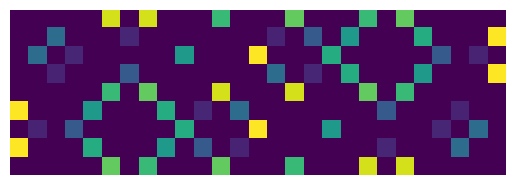

In [6]:
vis(V(SO(3)) ** 3, V(SO(3)) ** 2)

In [7]:
class O(SO):  #
    def __init__(self, n):
        """The Orthogonal group O(n) in n dimensions"""
        h_dense = torch.eye(n, device=DEFAULT_DEVICE)[None]
        h_dense[0, 0, 0] = -1

        self.discrete_generators = [MatrixLinearOperator(h) for h in h_dense]

        super().__init__(n)

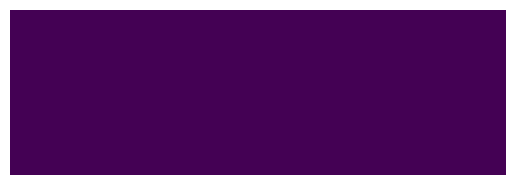

In [8]:
vis(
    V(O(3)) ** 3, V(O(3)) ** 2
);  # Unlike SO(n), O(n) has no solutions for odd parity V^3->V^2 = T5 = odd

In [9]:
class LazyPerm(LinearOperator):
    def __init__(self, perm):
        self.perm = perm
        self.shape = (len(perm), len(perm))
        self.dtype = torch.int64

    def matmat(self, V):
        return V[self.perm]

    def matvec(self, V):
        return V[self.perm]

    def adjoint(self):
        return LazyPerm(np.argsort(self.perm))

In [10]:
class AltFast(Group):
    """The alternating group in n dimensions"""

    def __init__(self, n):
        assert n > 2
        perms = (
            torch.zeros((n - 2, n), dtype=torch.int64, device=DEFAULT_DEVICE)
            + torch.arange(n, dtype=torch.int64, device=DEFAULT_DEVICE)[None]
        )
        for i in range(n - 2):
            ids = torch.tensor([0, 1, i + 2], dtype=torch.int64, device=DEFAULT_DEVICE)
            permed_ids = torch.roll(ids, 1)  # cyclic permutation (0,1,i+2)->(i+2,0,1)
            perms[i, ids] = perms[i, permed_ids]
        self.discrete_generators = [LazyPerm(perm) for perm in perms]
        super().__init__(n)

In [11]:
%timeit -n1 -r1 T(2)(Alt(100)).equivariant_basis()

Krylov Solving for Equivariant Subspace r<=10: 100%|█| 100/100 [00:10<00:00,  9.

10.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
%timeit -n1 -r1 T(2)(AltFast(100)).equivariant_basis()

Krylov Solving for Equivariant Subspace r<=10: 100%|█| 100/100 [00:10<00:00,  9.


11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
